# On the Application of ChirpGP on Non-Sinusoidal Interferometry Data

The instantaneous frequency (IF) of the time series of the reflectance of a growing thin film can be used to retrieve the growth behavior of this thin film. The baseline periodic function can generally be assumed to be known but might include shape parameters which have to be finetuned, e.g. the angle of measurement. For now these shape parameters can be assumed to be known / fixed. The signal shape will generally not be symmetric with respect to the x-axis, i.e. the hills might be sharp and the valleys flat. Also the zero-crossing will generally not be symmetric to the extrema. The amplitude of the periodic signal might generally vary, e.g. due to power instability of the laser (using a reference beam might alleviate this to some degree).

## Imports

In [2]:
# numerics
import jax.numpy as jnp

# plotting
import matplotlib.pyplot as plt

# use svg for plots
%config InlineBackend.figure_format = 'svg'

## Simplified Synthetic Data Generation

Let us here use an abstract form of a simplified model and a sine with the same frequency as a reference signal.

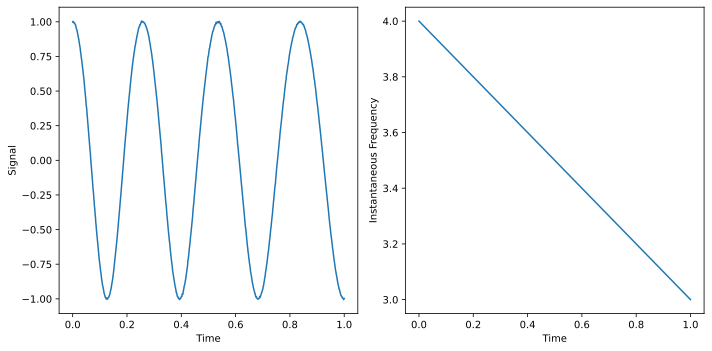

In [ ]:
import math
import jax

key = jax.random.PRNGKey(555)


def linear_frequency_model(base_frequency, frequency_slope, time):
    frequencies = base_frequency + frequency_slope * time
    phases = 0.5 * frequency_slope * time ** 2 + base_frequency * time
    return frequencies, phases


def simplified_abstract_model(phase, params):
    
    r01, r10, r12 = params
    delta = 2 * jnp.pi * phase

    signal = jnp.abs((r01 + r12 * jnp.exp(1j * delta)) / (1 - r10 * r12 * jnp.exp(1j * delta))) ** 2

    # normalize signal
    signal = (signal - signal.min()) / (signal.max() - signal.min()) * 2 - 1

    return signal


def add_noise(signal, noise_level):
    return signal + math.sqrt(noise_level) * jax.random.normal(key, shape=(signal.size,))


time = jnp.linspace(0, 1, 1000)
dt = time[1] - time[0]

base_frequency = 4.0
frequency_slope = -1.0

freqiencies, phases = linear_frequency_model(base_frequency, frequency_slope, time)

# typical parameter values
r01 = -0.17
r10 = 0.13
r12 = -0.40 - 0.0025j

# # more extreme parameter values -> less sinusoidal
# r01 = 0.5
# r10 = 0.5
# r12 = 0.5

params = (r01, r10, r12)

signal = simplified_abstract_model(phases, params)

# add noise
noise_level = 0.00001
signal = add_noise(signal, noise_level)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(time, signal)
ax1.set_xlabel('Time')
ax1.set_ylabel('Signal')

ax2.plot(time, freqiencies)
ax2.set_xlabel('Time')
ax2.set_ylabel('Instantaneous Frequency')

plt.tight_layout()

## ChirpGP Wrapper

In [4]:
import jax
import jaxopt
import jax.numpy as jnp
import jax.scipy.optimize
from reflax.data_analysis.chirpgp.models import g, g_inv, build_chirp_model
from reflax.data_analysis.chirpgp.filters_smoothers import ekf, eks, sgp_filter, sgp_smoother
from reflax.data_analysis.chirpgp.quadratures import SigmaPoints, gaussian_expectation


def instantaneous_frequency_analyzer(signal, dt, noise_level,
                                     sde_damping=0.01, sde_dispersion=0.01,
                                     chirp_initial_covariance=0.5,
                                     freq_length_scale=1., freq_magnitude_scale=1.,
                                     initial_model_mean=3.,
                                     bypass_mle: bool = False):
    """
    Estimates the instantaneous frequency of a signal and provides error estimates.
    
    Args:
        signal: The signal to be analyzed.
        dt: Time step in the signal, equal time differences between consecutive samples are assumed.
        noise_level: The noise level in the signal.
        sde_damping: Damping parameter in the SDE covariance functions. (formerly lambda)
        sde_dispersion: Dispersion parameter in the SDE covariance functions. (formerly b)
        chirp_initial_covariance: Initial covariance of the chirp model. (formerly delta)
        freq_length_scale: Instantaneous frequency prior length scale. (formely ell)
        freq_magnitude_scale: Instantaneous frequency prior magnitude scale. (formerly sigma)
        initial_model_mean: Initial mean of the chirp model (?). (formerly m0_1)

    Returns:
        estimated_freqs_mean: The estimated instantaneous frequencies.
        smoothing_results: The smoothing results.
    """

    # Sigma points
    sgps = SigmaPoints.gauss_hermite(d=4, order=3)

    # MLE parameter estimation
    init_theta = g_inv(jnp.array(
        [sde_damping, sde_dispersion, chirp_initial_covariance, freq_length_scale, freq_magnitude_scale,
         initial_model_mean]))

    # Objective function
    def obj_func(theta: jnp.ndarray):
        _, _, m_and_cov, m0, P0, H = build_chirp_model(g(theta))
        return sgp_filter(m_and_cov, sgps, H, noise_level, m0, P0, dt, signal)[-1][-1]

    # Optimise
    if bypass_mle:
        opt_params = jnp.array(
            [sde_damping, sde_dispersion, chirp_initial_covariance, freq_length_scale, freq_magnitude_scale,
             initial_model_mean])
    else:
        opt_solver = jaxopt.ScipyMinimize(method='L-BFGS-B', jit=True, fun=obj_func)
        opt_vals, opt_state = opt_solver.run(init_theta)
        opt_params = g(opt_vals)
        print(f'Parameter learnt: {opt_params}. Convergence: {opt_state}')

    # Filtering and smoothing based on the learnt parameters
    _, _, m_and_cov, m0, P0, H = build_chirp_model(opt_params)

    @jax.jit
    def filtering(measurements):
        return sgp_filter(m_and_cov, sgps, H, noise_level, m0, P0, dt, measurements)

    @jax.jit
    def smoothing(mfs, Pfs):
        return sgp_smoother(m_and_cov, sgps, mfs, Pfs, dt)

    # Trigger jit
    _dummy = filtering(jnp.ones((1,)))
    smoothing(_dummy[0], _dummy[1])

    # Compute posterior distributions
    filtering_results = filtering(signal)
    smoothing_results = smoothing(filtering_results[0], filtering_results[1])
    estimated_freqs_mean = gaussian_expectation(ms=smoothing_results[0][:, 2],
                                                chol_Ps=jnp.sqrt(smoothing_results[1][:, 2, 2]),
                                                func=g, force_shape=True)[:, 0]

    return estimated_freqs_mean, smoothing_results

## Application of ChirpGP on our non-sinusoidal signal

In [5]:
estimated_freqs_mean, smoothing_results = instantaneous_frequency_analyzer(
    signal=signal,
    dt=dt,
    noise_level=noise_level,
    sde_damping=0.01,
    sde_dispersion=0.01,
    chirp_initial_covariance=0.5,
    freq_length_scale=.3,
    freq_magnitude_scale=2.,
    initial_model_mean=3.
)

Parameter learnt: [0.01000001 0.01000001 0.49999997 0.30000004 2.         3.        ]. Convergence: ScipyMinimizeInfo(fun_val=Array(nan, dtype=float32, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32))


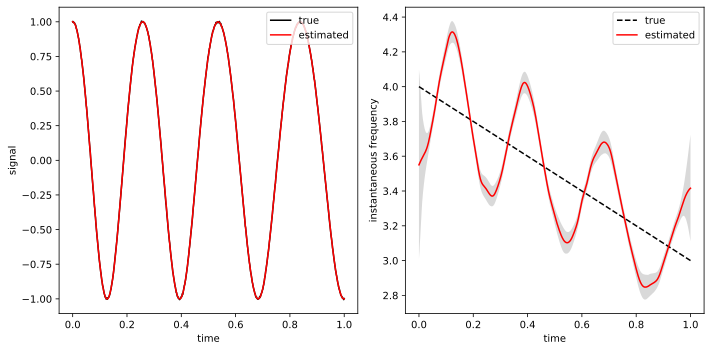

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(time, signal, label="true", color='black')
ax1.plot(time, smoothing_results[0][:, 1], label='estimated', color='red')
ax1.set_xlabel("time")
ax1.set_ylabel("signal")
ax1.legend(loc="upper right")

ax2.plot(time, freqiencies, "--", label="true", color='black')
ax2.plot(time, estimated_freqs_mean, label="estimated", color='red')
plt.fill_between(time,
                 g(smoothing_results[0][:, 2] - 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
                 g(smoothing_results[0][:, 2] + 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
                 color='black',
                 edgecolor='none',
                 alpha=0.15
                 )
ax2.set_xlabel("time")
ax2.set_ylabel("instantaneous frequency")
ax2.legend(loc="upper right")

plt.tight_layout()

The signal is fit very nicely but without knowing our signal form, there is no way for it to correctly distinguish between amplitude and frequency modulation - so the instantaneous frequency will not be correct. In a real world setting, our signal's amplitude might also be modulated so just fixing the amplitude is not a solution.

## Reference test on a sinusoidal signal

In [7]:
sine = jnp.cos(2 * jnp.pi * phases)

estimated_freqs_mean_sine, smoothing_results_sine = instantaneous_frequency_analyzer(
    signal=sine,
    dt=dt,
    noise_level=noise_level,
    sde_damping=0.01,
    sde_dispersion=0.01,
    chirp_initial_covariance=0.5,
    freq_length_scale=.3,
    freq_magnitude_scale=2.,
    initial_model_mean=3.
)

Parameter learnt: [0.01000001 0.01000001 0.49999997 0.30000004 2.         3.        ]. Convergence: ScipyMinimizeInfo(fun_val=Array(nan, dtype=float32, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32))


**NOTE** This result should be carefully interpreted, as you see from the previous return `Convergence: ScipyMinimizeInfo(fun_val=Array(nan, dtype=float32, weak_type=True)` saying that the optimisation failed.

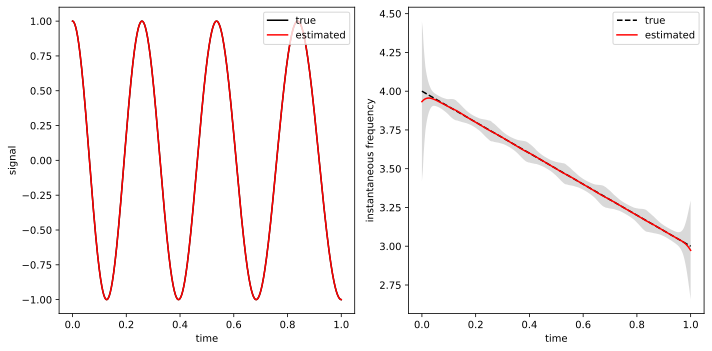

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(time, sine, label="true", color='black')
ax1.plot(time, smoothing_results_sine[0][:, 1], label='estimated', color='red')
ax1.set_xlabel("time")
ax1.set_ylabel("signal")
ax1.legend(loc="upper right")

ax2.plot(time, freqiencies, "--", label="true", color='black')
ax2.plot(time, estimated_freqs_mean_sine, label="estimated", color='red')
plt.fill_between(time,
                 g(smoothing_results_sine[0][:, 2] - 1.96 * jnp.sqrt(smoothing_results_sine[1][:, 2, 2])),
                 g(smoothing_results_sine[0][:, 2] + 1.96 * jnp.sqrt(smoothing_results_sine[1][:, 2, 2])),
                 color='black',
                 edgecolor='none',
                 alpha=0.15
                 )
ax2.set_xlabel("time")
ax2.set_ylabel("instantaneous frequency")
ax2.legend(loc="upper right")

plt.tight_layout()

This is the kind of result we would want for our signal :)

## Approach without MLE

I think I now get your problem setting. You want to estimate the frequency of a signal whose amplitude can be nasty (e.g., non-sine). This is exactly the purpose of our method. The reason that it does not work for your non-sine signal, is that it looks too clean (I guess) ... The catch is that although our model is flexible enough, the solver we are using is not.
In particular, the `sgd_smoother` is sensitive to these values and is prone to numerical errors. There are better alternatives of course, but I did not bother to implement them.

I have made higher measurement noise, and disabled the MLE. Now it should look better on your non-sine signal.

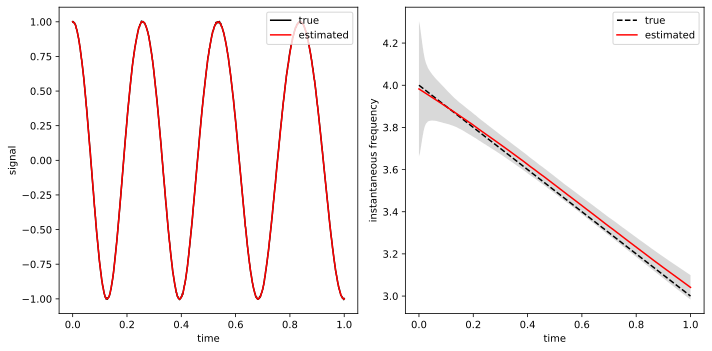

In [9]:
estimated_freqs_mean, smoothing_results = instantaneous_frequency_analyzer(
    signal=signal,
    dt=dt,
    noise_level=noise_level,
    sde_damping=1e-2,
    sde_dispersion=0.1,
    chirp_initial_covariance=1.,
    freq_length_scale=10,
    freq_magnitude_scale=1.,
    initial_model_mean=3.,
    bypass_mle=True
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(time, signal, label="true", color='black')
ax1.plot(time, smoothing_results[0][:, 1], label='estimated', color='red')
ax1.set_xlabel("time")
ax1.set_ylabel("signal")
ax1.legend(loc="upper right")

ax2.plot(time, freqiencies, "--", label="true", color='black')
ax2.plot(time, estimated_freqs_mean, label="estimated", color='red')
plt.fill_between(time,
                 g(smoothing_results[0][:, 2] - 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
                 g(smoothing_results[0][:, 2] + 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
                 color='black',
                 edgecolor='none',
                 alpha=0.15
                 )
ax2.set_xlabel("time")
ax2.set_ylabel("instantaneous frequency")
ax2.legend(loc="upper right")

plt.tight_layout()

We can distort your signal's amplitude in an even worse way, see below. The results will not be perfect, based on the first principle, but I don't think other methods can do better.

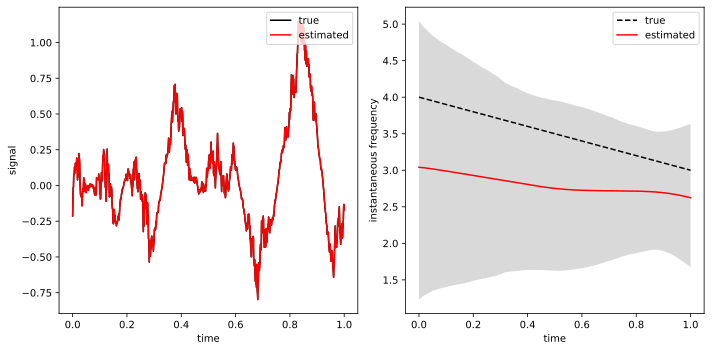

In [10]:
from reflax.data_analysis.chirpgp.toymodels import random_ou_mag


def even_harder_signal_generator(phase, params):
    r01, r10, r12 = params
    delta = 2 * jnp.pi * phase

    signal = jnp.abs((r01 + r12 * jnp.exp(1j * delta)) / (1 - r10 * r12 * jnp.exp(1j * delta))) ** 2

    # normalize signal
    signal = (signal - signal.min()) / (signal.max() - signal.min()) * 2 - 1

    return signal * random_ou_mag(0.5, 1., jax.random.PRNGKey(666))(time)

signal = even_harder_signal_generator(phases, params)
signal = add_noise(signal, noise_level)

estimated_freqs_mean, smoothing_results = instantaneous_frequency_analyzer(
    signal=signal,
    dt=dt,
    noise_level=noise_level,
    sde_damping=1e-2,
    sde_dispersion=1.,
    chirp_initial_covariance=1.,
    freq_length_scale=1.,
    freq_magnitude_scale=2.,
    initial_model_mean=3.,
    bypass_mle=True
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(time, signal, label="true", color='black')
ax1.plot(time, smoothing_results[0][:, 1], label='estimated', color='red')
ax1.set_xlabel("time")
ax1.set_ylabel("signal")
ax1.legend(loc="upper right")

ax2.plot(time, freqiencies, "--", label="true", color='black')
ax2.plot(time, estimated_freqs_mean, label="estimated", color='red')
plt.fill_between(time,
                 g(smoothing_results[0][:, 2] - 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
                 g(smoothing_results[0][:, 2] + 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
                 color='black',
                 edgecolor='none',
                 alpha=0.15
                 )
ax2.set_xlabel("time")
ax2.set_ylabel("instantaneous frequency")
ax2.legend(loc="upper right")

plt.tight_layout()

## Take-away message

1. The more nasty the signal is, the better our method will be compared to others (at the cost of careful tuning). If you have a clean-enough signal, I think even a simple Hilbert transform will just do.
2. It is possible to further improve the results by adapting both the model and the solver for your application, but this will take more efforts, and possibly leads to a paper. I am happy to discuss more.


## Hilbert transform on a clean signal

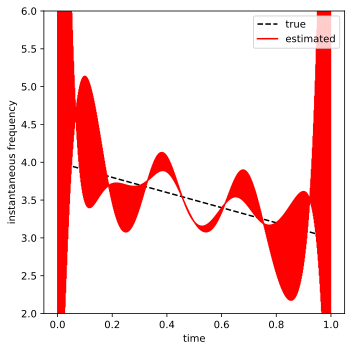

In [11]:
from reflax.data_analysis.chirpgp.classical_methods import hilbert_method

# generate the clean signal
signal = simplified_abstract_model(phases, params)

instantaneous_frequency = hilbert_method(time, signal)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(time, freqiencies, "--", label="true", color='black')
ax.plot(time[:-1], instantaneous_frequency, label="estimated", color='red')
ax.set_xlabel("time")
ax.set_ylabel("instantaneous frequency")
ax.legend(loc="upper right")

# y-limits
ax.set_ylim([2, 6])

plt.tight_layout()